### Q1

#### Q1.a + b

In [1]:
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

In [4]:
class SplitLinear(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        # layer's numbers of input and output features are halved by definition of the layer
        # number of output features will be the same as number of input features (section a.5 in the maman)
        self.in_features = in_features // 2
        self.out_features = in_features // 2
        # defining the layer and its parameters
        self.linear = torch.nn.Linear(self.in_features, self.out_features)
        # setting the weights and biases of the layer with uniform distributed values with the relevant size
        self.linear.weight = torch.nn.Parameter(torch.randn(size=(self.out_features, self.in_features)).to(device))
        self.linear.bias = torch.nn.Parameter(torch.ones(self.out_features).to(device))
        # the activation function of the layer
        self.activation = torch.nn.ReLU()
        
    def forward(self, X):
        # X shape is (N, M), asserting M is even
        N, M = X.shape
        assert M % 2 == 0
        # splitting the input into 2 - x1 has first M features and x2 has last M features
        print('Splitting input\'s features to 2 tensors...')
        x1, x2 = X[:, :M//2], X[:, M//2:]
        # passing both halves through the same linear layer
        print('Passing the 2 halves of the input to the same Linear layer...')
        x1 = self.linear(x1)
        x2 = self.linear(x2)
        print('Passing both halves to the activation function...')
        x1 = self.activation(x1)
        x2 = self.activation(x2)
        # concatenating the 2 halves to form the layer's output of the same size as X
        print('Concatenating the activation function\'s outputs into one tensor...')
        return torch.concat((x1, x2), dim=1)

#### Q1.c

In [5]:
example_model = torch.nn.Sequential(
    torch.nn.Linear(784, 30),
    torch.nn.ReLU(),
    SplitLinear(30)
)
example_model = example_model.to(device)

##### Loading a dataset

In [6]:
import torchvision
from torch.utils.data import DataLoader

In [7]:
dataset = torchvision.datasets.FashionMNIST(root='./fashion_mnist',
                                                           train=True,
                                                           download=True,
                                                           transform=torchvision.transforms.PILToTensor())
dataset.data.to(device)
dataset.targets.to(device)

# dataloader = DataLoader(dataset, batch_size=64, generator=torch.Generator(device=device))
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [8]:
for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
    example_batch_x = batch_x.reshape(len(batch_x), -1).to(device, torch.float32)
    example_batch_output = example_model(example_batch_x)
    break

Splitting input's features to 2 tensors...
Passing the 2 halves of the input to the same Linear layer...
Passing both halves to the activation function...
Concatenating the activation function's outputs into one tensor...


#### Q1.d - g

In [9]:
!conda install Wand -y

Channels:
 - conda-forge
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [1]:
from wand.image import Image as WImage
# first_page = WImage(filename='./maman14-ZivLazarov.pdf[0]')
# first_page

In [2]:
# second_page = WImage(filename='./maman14-ZivLazarov.pdf[1]')
# second_page

### Q2

#### Q2.a - c

In [12]:
def normalize_by_batch(input, epsilon=1e-5):
    mean = input.mean(dim=0).to(device)
    std = input.std(dim=0).to(device)
    return (input - mean) / (std + epsilon)

In [13]:
class DropNorm(torch.nn.Module):
    def __init__(self, in_features, epsilon=1e-5):
        super().__init__()
        self.in_features = in_features
        
        # layer's parameters
        self.gamma = torch.nn.Parameter(torch.ones(self.in_features).to(device))
        self.beta = torch.nn.Parameter(torch.zeros(self.in_features).to(device))
        
        # epsilon to avoid dividing by zero
        self.epsilon = epsilon
    
    def forward(self, X):
        # the number of features is the number output features from the previous layer, which is passed in the model's architecture definition
        # the batch size is the first dimension of the input
        batch_size, num_features = X.shape[0], self.in_features
        
        if self.training:                
            # uniform distributed weights for the feature selection
            random_sampling_weights = torch.ones(num_features).to(device) * 1/num_features
            # choose half of the features in input tensor
            selected_features_indices = torch.multinomial(random_sampling_weights, num_features // 2).to(device)
            # zeroing the selected features in the batch
            X[:, selected_features_indices] = 0
            # normalizing the other feature values w.r.t themselves
            X[:, ~selected_features_indices] = normalize_by_batch(input=X[:, ~selected_features_indices], epsilon=self.epsilon)
            # calculate output
            y = self.gamma * X + self.beta
            # zeroing the selected features indices as instructed in section a.4
            y[:, selected_features_indices] = 0
            return y
        else:
            y = normalize_by_batch(X, self.epsilon)
            y = 0.5 * y
            return self.gamma * y + self.beta


#### Q2.d

In [14]:
torch_model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 64),
    torch.nn.BatchNorm1d(64),
    # DropNorm zeroes 50% of the weights so we'll do the same
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.BatchNorm1d(64),
    # DropNorm zeroes 50% of the weights so we'll do the same
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10),
    torch.nn.LogSoftmax(dim=1)
)

torch_optimizer = torch.optim.Adam(torch_model.parameters(), lr=1e-4, betas=(0.99, 0.999))
# torch_optimizer = torch.optim.SGD(torch_model.parameters(), lr=1e-3, momentum=0.99)
torch_loss = torch.nn.CrossEntropyLoss()

torch_model = torch_model.to(device)

torch_model.train()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
)

In [15]:
def train(model, optimizer, loss, dataloader, epochs):
    torch_loss_metric, torch_accuracy_metric = torch.zeros(epochs).to(device), torch.zeros(epochs).to(device)
    
    for epoch in range(epochs):
        for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
            batch_X = batch_X.squeeze().reshape(len(batch_X), -1).to(device, torch.float32)
            batch_y = batch_y.to(device)
            # zero all previously calculated gradients
            optimizer.zero_grad()
            # pass batch through the layers
            batch_output = model(batch_X)
            # calculate loss
            batch_loss = loss(batch_output, batch_y)
            # calculate all gradients
            batch_loss.backward()
            # update parameters in all layers
            optimizer.step()
    
        # evaluating the data on learned weights until this point
        model.eval()
        
        epoch_preds = model(dataloader.dataset.data.to(device=device, dtype=torch.float32)).argmax(dim=1)
        epoch_accuracy = (epoch_preds == dataloader.dataset.targets.to(device=device)).sum() / len(dataloader.dataset.data)
        torch_accuracy_metric[epoch] = epoch_accuracy
        torch_loss_metric[epoch] = loss(epoch_preds.to(device=device, dtype=torch.float32), dataloader.dataset.targets.to(device=device, dtype=torch.float32)).item()
        
        # back to learning
        model.train()
            
            
    return torch_loss_metric, torch_accuracy_metric

In [16]:
loss_metric, accuracy_metric = train(model=torch_model,
      optimizer=torch_optimizer,
      loss=torch_loss,
      dataloader=dataloader,
      epochs=25)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

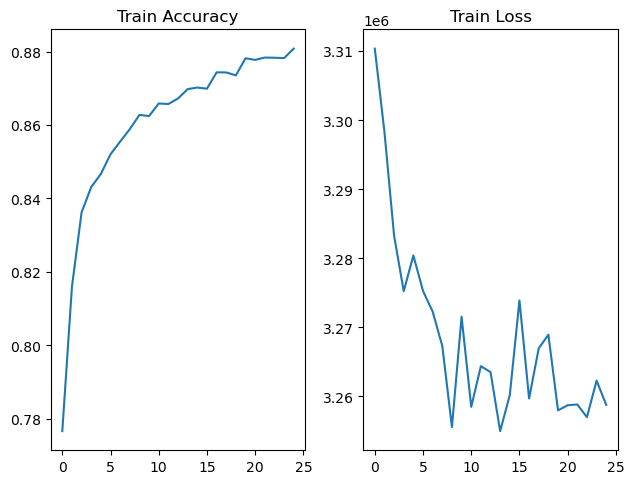

In [18]:
fig, axes = plt.subplots(1, 2)
fig.tight_layout()

axes[0].set_title('Train Accuracy')
axes[0].plot(accuracy_metric.cpu())

axes[1].set_title('Train Loss')
axes[1].plot(loss_metric.cpu())

In [19]:
test_dataset = torchvision.datasets.FashionMNIST(root='./fashion_mnist',
                                            train=False,
                                            download=True,
                                            transform=torchvision.transforms.PILToTensor())
test_dataset.data.to(device)
test_dataset.targets.to(device)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, generator=torch.Generator(device=device))

In [20]:
def test(model, dataloader, num_classes, plot=False):
    model.eval()
    
    accuracy = 0
    # creating the confusion matrix
    confusion_matrix = torch.zeros((num_classes, num_classes)).to(device)
    # traversing the test data in batches
    for batch_idx, (batch, batch_labels) in enumerate(dataloader):
        batch = batch.squeeze().reshape(len(batch), -1).to(device=device, dtype=torch.float32)
        batch_labels = batch_labels.to(device)
        # predicting the current batch and updating the accuracy and confusion matrix
        predictions = model(batch).argmax(dim=1).to(device)
        accuracy += (predictions == batch_labels).sum()
        for i in range(len(batch)):
            label_idx = batch_labels[i] - 1
            preds_idx = predictions[i] - 1
            confusion_matrix[label_idx, preds_idx] += 1

    if plot:
        accuracy = accuracy / (len(dataloader) * dataloader.batch_size)
        sns.heatmap(confusion_matrix.cpu(), annot=True, fmt='.4g')
        plt.ylabel('Label')
        plt.xlabel('Prediction')
        # plt.yticks(dataloader.dataset.targets, rotation=45)
        # plt.xticks(dataloader.dataset.targets, rotation=45)
        plt.title(f'Confusion Matrix - Accuracy: {accuracy}')

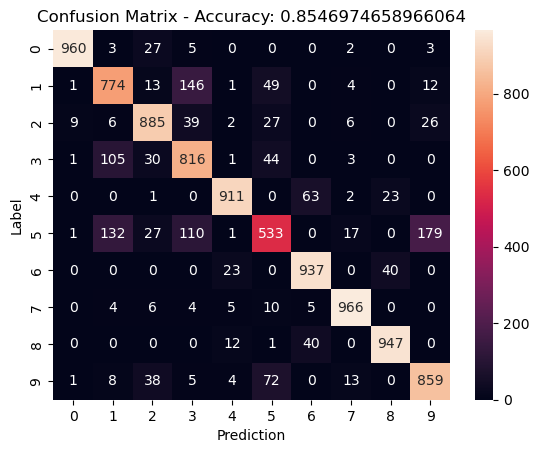

In [21]:
test(torch_model, test_dataloader, 10, plot=True)

#### Q2.e

#### Using our DropNorm layer

In [22]:
custom_model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 64),
    torch.nn.BatchNorm1d(64),
    DropNorm(64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.BatchNorm1d(64),
    DropNorm(64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.BatchNorm1d(64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10),
    torch.nn.LogSoftmax(dim=1)
)
custom_optimizer = torch.optim.Adam(custom_model.parameters(), lr=1e-4, betas=(0.99, 0.999))
# custom_optimizer = torch.optim.SGD(custom_model.parameters(), lr=5e-4, momentum=0.99)
custom_loss = torch.nn.CrossEntropyLoss()

custom_model = custom_model.to(device)

custom_model.train()

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): DropNorm()
  (4): ReLU()
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): DropNorm()
  (8): ReLU()
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
)

In [23]:
custom_loss_metric, custom_accuracy_metric = train(model=custom_model,
                       optimizer=custom_optimizer,
                       loss=custom_loss,
                       dataloader=dataloader,
                       epochs=25)

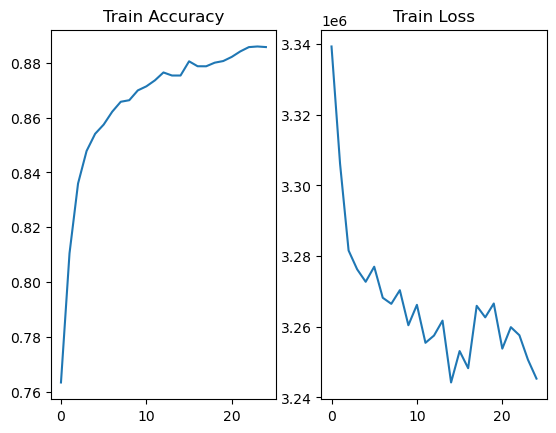

In [24]:
fig, axes = plt.subplots(1, 2)
axes[0].set_title('Train Accuracy')
axes[0].plot(custom_accuracy_metric.cpu())

axes[1].set_title('Train Loss')
axes[1].plot(custom_loss_metric.cpu())

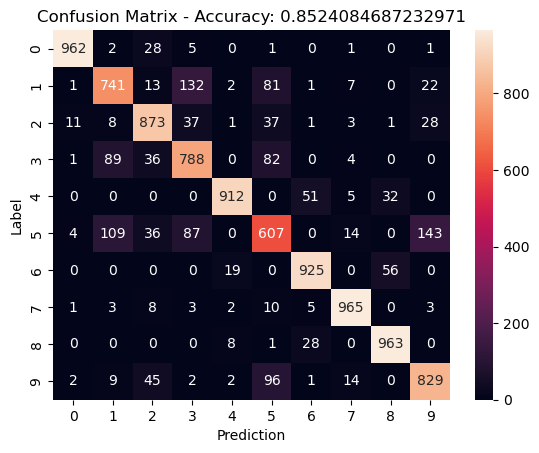

In [25]:
test(model=custom_model, dataloader=test_dataloader, num_classes=10, plot=True)

#### Q2.f

##### Both layers came with very similar results, where their loss and accuracy values were almost identical. I'll prefer using the built-in Dropout layer as the layer itself is written in C++ which is way faster than python. This leads to faster training and evaluation times. We can see from the confusion matrix that the model with the DropNorm layers had a hard time predicting 3 when it's actually 1, whereas the first model had a little easier time with it. Both models had roughly the same conclusions regarding the 5th and 9th classes. In conclusion, I don't see too much of a difference between the 2 layers.